## Stage 1: Dataset preparation

<img src="https://camo.githubusercontent.com/9059a83fc1e6b03d55f9bfbb2a8ce7252f3ca5c0c88b1e5d4ddd859e1a13c771/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830365f636f6d707265737365642f6f766572766965772d312e77656270" width=700px>

In [1]:
import urllib.request
import zipfile
import os
import pandas as pd
import tiktoken
from pathlib import Path

### 1. Download the dataset

In [2]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [3]:
df = pd.read_csv(data_file_path,
                 sep='\t',
                 header=None,
                 names=['Label', 'Text'])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
print(df['Label'].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


### 2. Preprocess the dataset

This is an unbalanced dataset, we choose to undersample the dataset to include 747 instances from each class.

In [5]:
def create_balanced_dataset(df):
    num_spam = df[df['Label'] == 'spam'].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df['Label'] == 'ham'].sample(num_spam, random_state=123)

    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df

In [6]:
balanced_df = create_balanced_dataset(df)
balanced_df['Label'].value_counts()

Label
ham     747
spam    747
Name: count, dtype: int64

In [7]:
# change 'ham' and 'spam' to 0 and 1 respectively
# > run this cell only once!!
balanced_df['Label'] = balanced_df['Label'].map({'ham': 0, 'spam': 1})
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [8]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

In [9]:
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [10]:
# save these dataframes as CSV
train_df.to_csv('train.csv', index=None)
validation_df.to_csv('validation.csv', index=None)
test_df.to_csv('test.csv', index=None)

### 3. Creating data loaders

<img src="https://camo.githubusercontent.com/ece05402ac93677bf7e055dff15138dc28198db2ca2dcd5908a706b9056c7249/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830365f636f6d707265737365642f7061642d696e7075742d73657175656e6365732e776562703f313233" width=700>

In [11]:
tokenizer = tiktoken.get_encoding('gpt2')
print(tokenizer.encode('<|endoftext|>', allowed_special={"<|endoftext|>"}))

[50256]


---

We first create the dataset class.

In [12]:
import torch
from torch.utils.data import Dataset

In [13]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data['Text']]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

        self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
                              for encoded_text in self.encoded_texts]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]['Label']

        return (torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long))

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length

        return max_length

In [14]:
train_dataset = SpamDataset(csv_file='train.csv', tokenizer=tokenizer, max_length=None)
train_dataset.max_length

120

In [15]:
val_dataset = SpamDataset(csv_file='validation.csv', tokenizer=tokenizer, max_length=train_dataset.max_length)

test_dataset = SpamDataset(csv_file='test.csv', tokenizer=tokenizer, max_length=train_dataset.max_length)

---

<img src="https://camo.githubusercontent.com/48d9b0183d7f0b78c3179eb8edbdc1a84ac287d577c538a83e93d987bf1bdc51/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830365f636f6d707265737365642f62617463682e77656270" width=600px>

Then we create PyTorch data loaders.

In [16]:
from torch.utils.data import DataLoader

In [17]:
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          drop_last=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          drop_last=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          drop_last=True)

In [18]:
for input_batch, target_batch in train_loader:
    pass

print(input_batch.shape, target_batch.shape)

torch.Size([8, 120]) torch.Size([8])


In [19]:
print(f'{len(train_loader)=}, {len(val_loader)=}, {len(test_loader)=} ')

len(train_loader)=130, len(val_loader)=18, len(test_loader)=37 


---

## Stage 2 : Model setup

<img src="https://camo.githubusercontent.com/80786c4d1d84976de2d804fd42bbae50157e4474f583d17a6f41aa0a2de8cf12/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830365f636f6d707265737365642f6f766572766965772d322e77656270" width=700>

### 4 & 5. Initializing a model with pretrained weights

In [20]:
CHOOSE_MODEL = 'gpt2-small (124M)'
INPUT_PROMPT = "Every effort moves you"
BASE_CONFIG  = {
    "vocab_size"     : 50257,
    "context_length" : 1024,
    "drop_rate"      : 0.0,
    "qkv_bias"       : True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [21]:
from gpt_download import download_and_load_gpt2
from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt

In [22]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [23]:
from llms_from_scratch.ch04 import generate_text_simple
from llms_from_scratch.ch05 import text_to_token_ids, token_ids_to_text

In [24]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(model,
                                 text_to_token_ids(text_1, tokenizer),
                                 max_new_tokens=15,
                                 context_size=BASE_CONFIG['context_length'])

print(token_ids)
print(token_ids_to_text(token_ids, tokenizer))

tensor([[6109, 3626, 6100,  345, 2651,   13,  198,  198,  464,  717, 2239,  318,
          284, 1833,  262, 6817,  286,  534,  670]])
Every effort moves you forward.

The first step is to understand the importance of your work


In [25]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(model=model,
                                 idx=text_to_token_ids(text_2, tokenizer),
                                 max_new_tokens=23,
                                 context_size=BASE_CONFIG["context_length"])

print(token_ids)
print(token_ids_to_text(token_ids, tokenizer))

tensor([[ 3792,   262,  1708,  2420,   705,  2777,   321, 30960, 23998,   351,
           705,  8505,     6,   393,   705,  3919, 10354,   705,  1639,   389,
           257,  8464,   345,   423,   587, 20905,  6163,   284,  3328,   720,
         12825,  5003,   393,   257,   720, 11024,  5764,  2637,   198,   198,
           464,  1708,  2420,   705,  2777,   321, 30960, 23998,   351,   705,
          8505,     6,   393,   705,  3919, 10354,   705,  1639,   389,   257,
          8464]])
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


The model is **not** following our instructions because it lacks instructions fine-tuning. 💀💀

### 6. Adding a classification head

<img src="https://camo.githubusercontent.com/424818dc46ac91f5b7e1d37a59f9e2374deacfa04348569e4706e75f769de6ee/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830365f636f6d707265737365642f6c6d2d686561642e77656270" width=700>

In [26]:
# freeze the model
for param in model.parameters():
    param.requires_grad = False

# replace out_head with a classification layer (linear)
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG['emb_dim'],
                                 out_features=num_classes)

# make the last transformer block & final norm trainable to improves performance
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

---

In [27]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
inputs, inputs.shape # (batch, num_tokens)

(tensor([[5211,  345,  423,  640]]), torch.Size([1, 4]))

In [28]:
with torch.no_grad():
    outputs = model(inputs)
outputs, outputs.shape # (batch, num_tokens, num_classes)

(tensor([[[-1.5854,  0.9904],
          [-3.7235,  7.4548],
          [-2.2661,  6.6049],
          [-3.5983,  3.9902]]]),
 torch.Size([1, 4, 2]))

In [29]:
"Last output token:", outputs[:, -1, :,]

('Last output token:', tensor([[-3.5983,  3.9902]]))

We focus on the last token because it is the only one with an attention score to all other tokens.

=> It is the one that accumulates (with access to all previous tokens) **the most information**!

<center><img src="https://camo.githubusercontent.com/c5df498a5a829eff94b40722fb100b96e6408fb54b494fbf6680d0acef04a37d/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830365f636f6d707265737365642f617474656e74696f6e2d6d61736b2e77656270" width=300></center>

### 7. Computing classification loss and accuracy

Easy : use a `softmax` on the 2D outputs and return the highest probability

In [35]:
probas = torch.softmax(outputs[:, -1, :,], dim=-1)
label = torch.argmax(probas)
label.item()

1

In [37]:
# above cell is equivalent to this cell
logits = outputs[:, -1, :,]
label = torch.argmax(logits)
label.item()

1

In [38]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [41]:
device = torch.device('cpu')
model.to(device);

In [43]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader,
                                      model,
                                      device,
                                      num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader,
                                      model,
                                      device,
                                      num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader,
                                      model,
                                      device,
                                      num_batches=10)

print(f'Train: {train_accuracy*100:.2f}%\nVal: {val_accuracy*100:.2f}%\nTest: {test_accuracy*100:.2f}%\n')

Train: 46.25%
Val: 53.75%
Test: 50.00%



In [47]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:, -1, :,]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [48]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
            
    return total_loss / num_batches

In [49]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 1.937
Validation loss: 2.585
Test loss: 2.428


## Stage 3 : Model fine-tuning and usage

### 8 & 9. Finetune model on supervised data, evaluate fined-tuned model

In [54]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [55]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    
    return train_loss, val_loss

In [56]:
%%time
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.859
Ep 1 (Step 000050): Train loss 0.631, Val loss 0.618
Ep 1 (Step 000100): Train loss 0.498, Val loss 0.561
Training accuracy: 75.00% | Validation accuracy: 77.50%
Ep 2 (Step 000150): Train loss 0.494, Val loss 0.508
Ep 2 (Step 000200): Train loss 0.363, Val loss 0.479
Ep 2 (Step 000250): Train loss 0.455, Val loss 0.360
Training accuracy: 70.00% | Validation accuracy: 92.50%
Ep 3 (Step 000300): Train loss 0.414, Val loss 0.442
Ep 3 (Step 000350): Train loss 0.485, Val loss 0.344
Training accuracy: 87.50% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.220, Val loss 0.190
Ep 4 (Step 000450): Train loss 0.204, Val loss 0.196
Ep 4 (Step 000500): Train loss 0.147, Val loss 0.091
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.123, Val loss 0.078
Ep 5 (Step 000600): Train loss 0.054, Val loss 0.090
Training accuracy: 95.00% | Validation accuracy: 95.00%
CPU times: user 27min 18s, sys:

---

In [63]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(10, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    ax1.grid()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

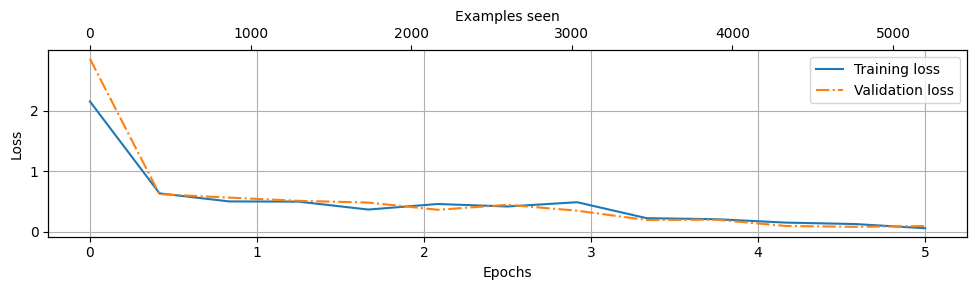

In [64]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

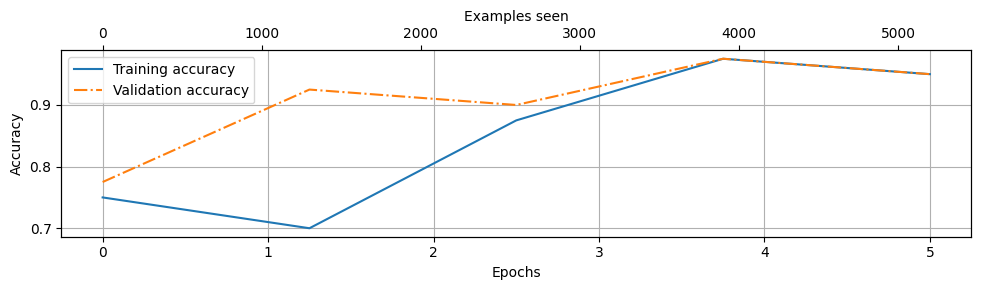

In [65]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [66]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.12%
Validation accuracy: 96.53%
Test accuracy: 95.61%


### 10. Use model on new data

In [67]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    
    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)
    
    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]
    
    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension
    
    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()
    
    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [71]:
text_1 = "You are a winner! $1000 cash or a $2000 award?"

print(text_1, classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length), sep='\n')

You are a winner! $1000 cash or a $2000 award?
spam


In [72]:
text_2 = "Hey, how are you? Wanna go grab a coffee later?"

print(text_2, classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length), sep='\n')

Hey, how are you? Wanna go grab a coffee later?
not spam


---

In [75]:
# saving the model
torch.save(model.state_dict(), "review_classifier.pth")

In [77]:
# loading the model
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict);